## Autoencoder transformation (encode-decode)

Considering a dataset with $p$ numerical attributes. 

The goal of the autoencoder is to reduce the dimension of $p$ to $k$, such that these $k$ attributes are enough to recompose the original $p$ attributes. However from the $k$ dimensionals the data is returned back to $p$ dimensions. The higher the quality of autoencoder the similiar is the output from the input. 

In [1]:
# DAL ToolBox
# version 1.1.727

source("https://raw.githubusercontent.com/cefet-rj-dal/daltoolbox/main/jupyter.R")

library(tidyverse)
library(torchvision)
library(imager)
library(caret)
library(stringr)
library(devtools)
load_all("/home/lucas/daltoolbox_autoenc")
#loading DAL
# load_library("daltoolbox")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
ℹ Additional software needs to be downloaded and installed for torch to work correctly.



Do you want to continue? (Yes/no/cancel)  yes


Warning message:
“ℹ Failed to install torch, manually run `install_torch()`
Unsupported CUDA version "11.5"
Caused by error in `check_supported_version()`:
✖ Unsupported CUDA version "11.5"
ℹ Currently supported versions are: "11.7" and "11.8".”
Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘imager’


The following object is masked from ‘package:magrittr’:

    add


The following object is masked from ‘package:stringr’:

    boundary


The following object is masked from ‘package:dplyr’:

    where


The following object is masked from ‘package:tidyr’:

    fill


The following objects are masked from ‘package:stats’:

    convolve, spectrum


The following object is masked from ‘package:graphics’:

    frame


The following object is masked from ‘package:base’:

    save.image


Loading required package: l

### dataset for example 

In [2]:
dataset_path <- '/home/lucas/datasets/images/kaggle_chest_c19_xrays/'
folder_list <- head(list.files(paste0(dataset_path, 'images/')), 3)
folder_paths <- paste0(dataset_path, 'images/', folder_list, '/images/')
file_names <- map(folder_paths, function(x) paste0(x, list.files(x))) %>%
  unlist()

# Print total number of images
print(length(file_names))

[1] 19820


### sampling one image for each class

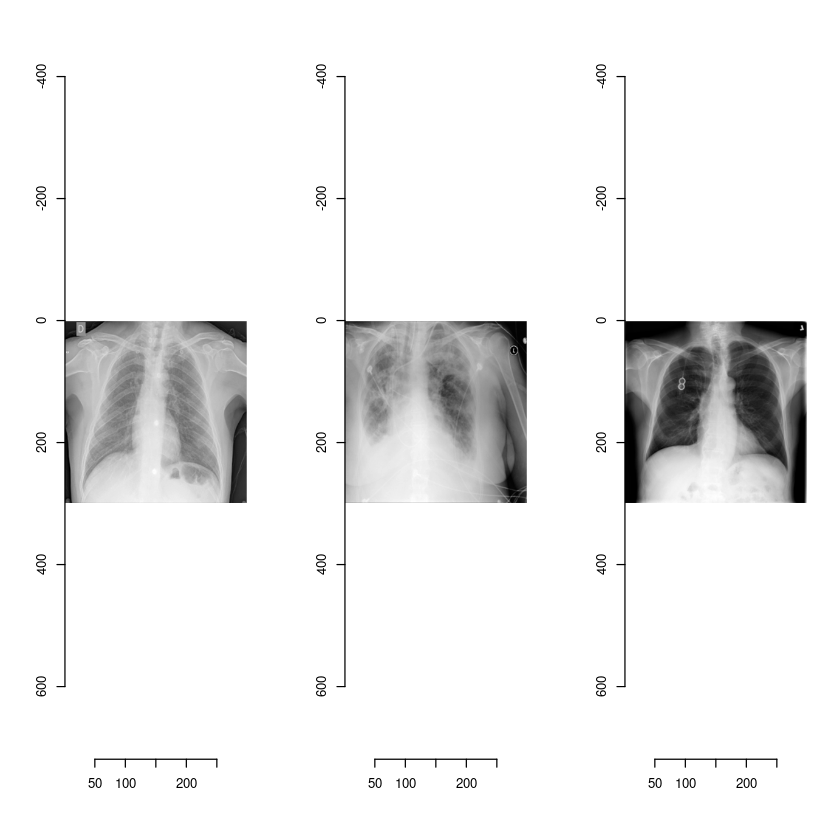

In [3]:
class_examples <- c()
for (image_class in folder_list){
  class_images <- str_detect(file_names, image_class)
  class_example <- sample(file_names[class_images], 1)
  
  class_examples <- c(class_examples, class_example)
}

# Plot samples
img <- map(class_examples, load.image)

par(mfrow=(c(1,3)))
p <- map(img, plot)

### spliting into training and test

In [4]:
# Sample the data
sample_images <- sample(file_names, 400)

# Check dimensions
img <- load.image(file_names[1])
dim(img)

get_dim <- function(x){
  img <- load.image(x) 
  
  df_img <- data.frame(height = height(img),
                       width = width(img),
                       filename = x
  )
  
  return(df_img)
}

dim_df <- map_df(sample_images, get_dim)

input_size <- as.array(c(1, as.vector(unlist(dim_df[1, c('height', 'width')]))))

[1] 299 299   1   1

### spliting in train and test

In [5]:
# Create Dataset
sample_size <- length(sample_images)/2
train <- array(0, c(length(sample_images)/2, input_size[1], input_size[2], input_size[3]))
test <- array(0, c(length(sample_images)/2, input_size[1], input_size[2], input_size[3]))
a <- 1
for (i in sample_images[1:sample_size]){
  if (a <= sample_size){
    train[a, 1, , ] <- as.array(load.image(i))
  }else{
    test[a, 1, , ] <- as.array(load.image(i))
  }
  a <- a + 1
}

dim(train)
dim(test)

[1] 200   1 299 299

[1] 200   1 299 299

### creating autoencoder
Reduce from 5 to 3 dimensions

In [ ]:
auto <- cae2den_encode_decode(input_size, encoding_size=200, batch_size=100, num_epochs=250, learning_rate=0.01)

auto <- fit(auto, train)

### learning curves

In [ ]:
auto <- fit(auto, train)

train_loss <- unlist(auto$model$train_loss)
val_loss <- unlist(auto$model$val_loss)

fit_loss <- as.data.frame(cbind(train_loss, val_loss))
fit_loss['epoch'] <- 1:nrow(fit_loss)

ggplot(fit_loss, aes(x=epoch)) +
geom_line(aes(y=train_loss, colour='Train Loss')) +
geom_line(aes(y=val_loss, colour='Val Loss')) +
scale_color_manual(values=c('Blue','Orange')) +
theme_classic()

### testing autoencoder
presenting the original test set and display encoding

In [ ]:
result <- transform(auto, test)

example_result <- result[1, 1, , ]

dim(example_result)

example_result[example_result > 1] <- 1

rotate <- function(x) t(apply(x, 2, rev))

plot_image <- function(x, col, img_list=plot_comparison){
image(plot_comparison[[x]], col=col)
title(x)
}

plot_comparison <- list()

plot_comparison[['Input']] <- rotate(rotate(as.matrix(load.image(sample_images[length(sample_images)/2]))))
plot_comparison[['Reconstructed']] <- rotate(rotate(as.matrix(example_result)))

par(mfrow=(c(1,2)))
map(names(plot_comparison), plot_image, col=grey.colors(50), img_list=plot_comparison)